# Code

**Team:** Kamil Grudzień, Krystian Sztenderski, Jakub Bednarz.

**Project:** (V) Time-dependent explanations of neural networks for survival analysis.

## Introduction

**What was done?** We've:

1. Learned how to use the `pycox` package, in particular the DeepHit survival analysis model.
2. Learned how to use the `sksurv` package.
3. Wrapped various models (Cox proportional hazards, Random Survival Forest and DeepHit) into an uniform interface to make training and evaluation easier.
4. Read the [SurvSHAP(t) paper](https://arxiv.org/abs/2208.11080) and the [implementation provided by the authors](https://github.com/MI2DataLab/survshap).
5. Learned how to use various NN-specific explainability techniques from the `captum` library - in particular, we've adapted the `DeepLift`, `DeepLiftShap` and `IntegratedGradients` methods to provide explanations for DeepHit analogous to the ones given by SurvSHAP(t).
6. Wrapped all of them into a single interface to compare them "on equal ground."
7. Replicated experiment from the SurvSHAP(t) paper to verify we're using the library correctly. Beyond that, we've also trained and evaluated DeepHit on the same dataset, obtained ground-truth explanations with SurvSHAP(t) and ran DeepLift, DeepLiftShap and Integrated Gradients to see how NN-specific explanations compare with SurvSHAP(t).
8. We've also performed a preliminary experiment on a real-world dataset (METABRIC) in a similar fashion to one described in (7).
9. For experiments in (7) and (8), we've made a "coarse-grained analysis of the results.", i.e. we've made plots of the SHAP values at given time points and evaluated them qualitatively.

**What are the difficulties?**

1. The NN-specific explanations do not *seem* to correlate at all with the ground-truth, so a further analysis would be needed.
2. Although we evaluate the models quantitatively (via concordance index,) we still don't exactly know if the models we've trained for these dataset give "reasonable results". Of course, if the model does not perform well, the explanations given would be meaningless, so it would be wise to eliminate that cause of uncertainty.

**What will be done next?**

1. Adding quantitative metrics for comparing the explanations given by SurvSHAP(t) and other methods.
2. Performing deeper analysis of the trained models and the explanations.
3. (Possibly) Testing other NNs for survival analysis than DeepHit.
4. Adding measurement of execution time.

In [1]:
import numpy as np
import pandas as pd
from ruamel.yaml import safe_load
import scipy.integrate
import scipy.optimize
from scipy.interpolate import interp1d

from warnings import catch_warnings, simplefilter
from dataclasses import dataclass
from typing import Callable, Optional, Any
from tqdm import tqdm

import plotly.graph_objects as go
import plotly.offline as py
import plotly.io as pio
pio.renderers.default = "jpeg"

import torch
import torch.nn as nn
import torch.optim as optim
import torchtuples as tt

import sksurv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.datasets import get_x_y
from sksurv.functions import StepFunction
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
from sklearn.model_selection import train_test_split

from pycox.datasets import metabric
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from pycox.models import DeepHitSingle

from survshap import SurvivalModelExplainer, ModelSurvSHAP, PredictSurvSHAP

from captum.attr import DeepLift, IntegratedGradients, DeepLiftShap

## DeepHit adapter

In [2]:
@dataclass
class TrainConf:
    optimizer_fn: Callable[[nn.Module], optim.Optimizer] \
        = lambda net: optim.Adam(net.parameters(), lr=1e-3)
    device: Optional[torch.device] = None
    batch_size: int = 256
    epochs: int = 1
    callbacks: Any = None
    verbose: bool = False
    num_workers: int = 0
    shuffle: bool = False
    metrics: Any = None
    val_data: Optional[torch.Tensor] = None
    val_batch_size: int = 8224


class DeepHitSingle_:
    """A sksurv-like wrapper around pycox's DeepHitSingle."""

    def __init__(self, net: nn.Module, timestamps=None, alpha=0.2, sigma=0.1):
        """Create an instance.
        :param net: NN at the core of DeepHit. The number of output features
         is the number of cuts/timestamps.
        :param timestamps: (Optional) Predefined timestamps/steps to use. 
        Number of them must be equal to the dimensionality of net's output 
        space. If not provided, default cuts are used (see pycox docs for more 
        details.)
        :param alpha, sigma: Parameters for the pycox.models.DeepHitSingle 
        class."""

        self.net = net
        self.timestamps = None
        self.alpha = alpha
        self.sigma = sigma
    
    def fit(self, X, y, conf: Optional[TrainConf] = None):
        if conf is None:
            conf = TrainConf()

        # Get the timestamps/cuts
        if self.timestamps is not None:
            cuts = self.timestamps
        else:
            # If the cuts are unspecified, we guess it by dry-running the net 
            # and checking the dimensionality of the output space.
            with torch.no_grad():
                self.net.eval()
                num_features = X.shape[1]
                dummy = torch.empty((1, num_features), dtype=torch.float32)
                res = self.net(dummy)[0]
                self.net.train()
            cuts = res.shape[0]
        
        self.tf = DeepHitSingle.label_transform(cuts)

        # Encode X and y to a form acceptable for DeepHitSingle.
        def encode(X, y, fit=False):
            input = torch.tensor(np.asarray(X), dtype=torch.float32)
            if fit:
                self.tf.fit(y["duration"], y["event"])
            durations, events = self.tf.transform(y["duration"], y["event"])
            durations = torch.tensor(durations, dtype=torch.int64)
            events = torch.tensor(events, dtype=torch.float32)
            target = (durations, events)
            return input, target
        
        input, target = encode(X, y, fit=True)
            
        self._model = DeepHitSingle(
            net=self.net,
            optimizer=conf.optimizer_fn(self.net),
            device=conf.device,
            duration_index=self.tf.cuts,
            alpha=self.alpha,
            sigma=self.sigma,
        )

        if conf.val_data is not None:
            val_X, val_y = conf.val_data
            val_data = encode(val_X, val_y)
        else:
            val_data = None

        self._log = self._model.fit(input, target, conf.batch_size, conf.epochs,
            conf.callbacks, conf.verbose, conf.num_workers, conf.shuffle,
            conf.metrics, val_data, conf.val_batch_size)
        
        self.event_times_ = self.tf.cuts
        
        return self
    
    def predict_surv_df(self, X):
        X = torch.tensor(np.asarray(X), dtype=torch.float32)
        return self._model.predict_surv_df(X).astype("float32")
    
    def predict_survival_function(self, X, return_array=False):
        """Predict survival function. See sksurv models for more details."""

        surv_df = self.predict_surv_df(X)

        event_times_ = surv_df.index.values
        sf_values = surv_df.T.values

        if return_array:
            return sf_values
        else:
            return np.array([
                StepFunction(event_times_, values)
                for values in sf_values
            ])

    def predict_cumulative_hazard_function(self, X, return_array=False):
        raise NotImplementedError
    
    def score(self, X, y):
        surv = self.predict_surv_df(X)

        with catch_warnings():
            simplefilter("ignore")
            eval = EvalSurv(
                surv=surv,
                durations=y["duration"],
                events=y["event"],
                censor_surv="km",
            )
            return eval.concordance_td(method="antolini")

## Attribution methods

### SurvSHAP(t) Adapter

In [3]:
class SurvShapExplainer:
    """A bit more shap-esque Explainer wrapper for SurvSHAP."""

    def __init__(self, model, data=None, y=None, calculation_method="kernel", aggregation_method="integral", path="average", B=25, random_state=42, pbar=False):
        self.model = model
        self.calculation_method = calculation_method
        self.aggregation_method = aggregation_method
        self.path = path
        self.B = B
        self.random_state = random_state
        self.exp = SurvivalModelExplainer(self.model, data=data, y=y)
        self.pbar = pbar

    def __call__(self, observations: pd.DataFrame, timestamps=None) -> pd.DataFrame:
        """Predict SHAP values for a number of observations. In this case, we 
        deal with survival functions in the form of StepFunction, so likewise 
        the output SHAP values will be step functions.
        :param observations: Dataframe with shape (num_obs, num_features).
        :return: A dataframe with shape (num_obs, num_features), where each 
        "cell" contains a StepFunction being the SHAP attribution for a given 
        observation and a given value."""

        if timestamps is None:
            timestamps = self.model.event_times_

        skip = ["variable_str", "variable_name", "variable_value", "B", "aggregated_change", "index"]

        all_results = []
        
        idx_seq = range(len(observations))
        if self.pbar:
            idx_seq = tqdm(idx_seq)
        
        for idx in idx_seq:
            obs = observations.iloc[[idx]]
            shap = PredictSurvSHAP(
                calculation_method=self.calculation_method,
                aggregation_method=self.aggregation_method,
                path=self.path,
                B=self.B,
                random_state=self.random_state,
            )

            shap.fit(self.exp, obs, timestamps)
            obs_df = shap.result
            obs_df.insert(len(skip)-1, "index", idx)
            all_results.append(obs_df)
        
        res_df = pd.concat(all_results)
            
        g = res_df.groupby(by="variable_name")

        var_attr_values = {}
        for var in g.groups:
            grp: pd.DataFrame = g.get_group(var)
            grp = grp.sort_values(by=["index"])
            attr_values = grp.iloc[:,len(skip):].values
            var_attr_values[var] = [
                StepFunction(timestamps, attr_values_)
                for attr_values_ in attr_values
            ]
            
        res_df = pd.DataFrame(var_attr_values)
        res_df = res_df.set_index(observations.index, drop=True)
        return res_df

### DeepLift Adapter

In [4]:
class DeepLiftExplainer:
    """A shap-esque wrapper for DeepLift. See SurvShapExplainer for more
     details."""
     
    def __init__(self, model: DeepHitSingle_, data=None, y=None):
        self.model = model
        if data is not None:
            data = torch.tensor(data.values, dtype=torch.float32)
            self.baselines = data.mean(dim=0)
        else:
            self.baselines = None
    
    def __call__(self, X: pd.DataFrame):
        inputs = torch.tensor(X.values, dtype=torch.float32)
        if self.baselines is not None:
            baselines = self.baselines.broadcast_to(inputs.shape)
        else:
            baselines = inputs.mean(dim=0).broadcast_to(inputs.shape)

        deep_lift = DeepLift(self.model.net)

        with catch_warnings():
            simplefilter("ignore")
            attr_values = []
            for idx in range(len(self.model.event_times_)):
                attrs = deep_lift.attribute(inputs, baselines, target=idx)
                attr_values.append(attrs)
            attr_values = torch.stack(attr_values, dim=2).detach().numpy()

        var_attr_values = {}
        for var_idx, var in enumerate(X.columns):
            var_attr_values[var] = [
                StepFunction(
                    x=self.model.event_times_,
                    y=np.cumsum(attr_values[obs_idx,var_idx]),
                ) for obs_idx in range(len(X))
            ]
        
        return pd.DataFrame(var_attr_values)

### DeepLiftShap Adapter

In [5]:
class DeepLiftShapExplainer:
    """A shap-esque wrapper for DeepLiftShap. See SurvShapExplainer for more
     details."""
     
    def __init__(self, model: DeepHitSingle_, data=None, y=None):
        self.model = model
        if data is not None:
            self.baselines = torch.tensor(data.values, dtype=torch.float32)
        else:
            self.baselines = None
    
    def __call__(self, X: pd.DataFrame):
        inputs = torch.tensor(X.values, dtype=torch.float32)
        if self.baselines is not None:
            baselines = self.baselines
        else:
            baselines = inputs

        deep_lift_shap = DeepLiftShap(self.model.net)

        with catch_warnings():
            simplefilter("ignore")
            attr_values = []
            for idx in range(len(self.model.event_times_)):
                attrs = deep_lift_shap.attribute(
                    inputs, baselines, target=idx)
                attr_values.append(attrs)
            attr_values = torch.stack(attr_values, dim=2).detach().numpy()

        var_attr_values = {}
        for var_idx, var in enumerate(X.columns):
            var_attr_values[var] = [
                StepFunction(
                    x=self.model.event_times_,
                    y=np.cumsum(attr_values[obs_idx,var_idx]),
                ) for obs_idx in range(len(X))
            ]
        
        return pd.DataFrame(var_attr_values)

### Integrated Gradients (IG) Adapter

In [6]:
class IGExplainer:
    def __init__(self, model: DeepHitSingle_, data=None, y=None):
        self.model = model
        if data is not None:
            data = torch.tensor(data.values, dtype=torch.float32)
            self.baselines = data.mean(dim=0)
        else:
            self.baselines = None
    
    def __call__(self, X: pd.DataFrame):
        inputs = torch.tensor(X.values, dtype=torch.float32)
        if self.baselines is not None:
            baselines = self.baselines.broadcast_to(inputs.shape)
        else:
            baselines = inputs.mean(dim=0).broadcast_to(inputs.shape)

        ig = IntegratedGradients(self.model.net)

        with catch_warnings():
            simplefilter("ignore")
            attr_values = []
            for idx in range(len(self.model.event_times_)):
                attrs = ig.attribute(inputs, baselines, target=idx)
                attr_values.append(attrs)
            attr_values = torch.stack(attr_values, dim=2).detach().numpy()

        var_attr_values = {}
        for var_idx, var in enumerate(X.columns):
            var_attr_values[var] = [
                StepFunction(
                    x=self.model.event_times_,
                    y=np.cumsum(attr_values[obs_idx,var_idx]),
                ) for obs_idx in range(len(X))
            ]
        
        return pd.DataFrame(var_attr_values)

## Checking if the SurvSHAP adapter works fine

### Data - `exp1_data.csv`

In [7]:
def exp1_csv():
    df = pd.read_csv("data/exp1_data.csv")
    df = df.rename(columns={"time": "duration"})
    return df

exp1_df = exp1_csv()

In [8]:
df = exp1_df

X, y = get_x_y(df, attr_labels=["event", "duration"], pos_label=1)
train_X = test_X = X
train_y = test_y = y

# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# train_X, train_y = get_x_y(train_df, 
#     attr_labels=["event", "duration"], pos_label=1)
# test_X, test_y = get_x_y(test_df, 
#     attr_labels=["event", "duration"], pos_label=1)

In [9]:
def eval_model(model, name):
    print(f"[{name}] Train score: {model.score(train_X, train_y)}")
    print(f"[{name}] Test score: {model.score(test_X, test_y)}")

### Linear model (`CoxPHSurvivalAnalysis`)

In [10]:
cph = CoxPHSurvivalAnalysis()
cph = cph.fit(train_X, train_y)
eval_model(cph, "cph")

[cph] Train score: 0.622925665249838
[cph] Test score: 0.622925665249838


### Random survival forest

In [11]:
rsf = RandomSurvivalForest(
    random_state=42,
    n_estimators=100,
    min_samples_split=8,
    min_samples_leaf=4,
    max_features=3,
    max_samples=0.8,
)

rsf = rsf.fit(train_X, train_y)
eval_model(rsf, "rsf")

[rsf] Train score: 0.8095397887950072
[rsf] Test score: 0.8095397887950072


### DeepHit

In [12]:
net = tt.practical.MLPVanilla(train_X.shape[1], [32, 32], 91, True, 0.1)
deephit_ = DeepHitSingle_(net, alpha=0.2, sigma=0.1)

x_train, x_val, y_train, y_val = \
    train_test_split(train_X, train_y, test_size=0.2, random_state=42)

conf = TrainConf(
    optimizer_fn=lambda net: torch.optim.Adam(net.parameters(), lr=1e-2),
    epochs=100,
    callbacks=[tt.callbacks.EarlyStopping()],
    batch_size=256,
    val_data=(x_val, y_val),
    verbose=True,
)

deephit_ = deephit_.fit(x_train, y_train, conf=conf)
eval_model(deephit_, "deephit")

0:	[0s / 0s],		train_loss: 0.9290,	val_loss: 1.2544
1:	[0s / 0s],		train_loss: 0.8861,	val_loss: 1.0744
2:	[0s / 0s],		train_loss: 0.8643,	val_loss: 0.9914
3:	[0s / 0s],		train_loss: 0.8422,	val_loss: 0.9617
4:	[0s / 0s],		train_loss: 0.8177,	val_loss: 0.9514
5:	[0s / 0s],		train_loss: 0.8074,	val_loss: 0.9501
6:	[0s / 0s],		train_loss: 0.7789,	val_loss: 0.9507
7:	[0s / 0s],		train_loss: 0.7775,	val_loss: 0.9529
8:	[0s / 0s],		train_loss: 0.7697,	val_loss: 0.9532
9:	[0s / 0s],		train_loss: 0.7536,	val_loss: 0.9541
10:	[0s / 0s],		train_loss: 0.7490,	val_loss: 0.9605
11:	[0s / 0s],		train_loss: 0.7458,	val_loss: 0.9639
12:	[0s / 0s],		train_loss: 0.7322,	val_loss: 0.9606
13:	[0s / 0s],		train_loss: 0.7381,	val_loss: 0.9669
14:	[0s / 0s],		train_loss: 0.7215,	val_loss: 0.9816
15:	[0s / 0s],		train_loss: 0.7144,	val_loss: 0.9726
[deephit] Train score: 0.652876965347926
[deephit] Test score: 0.652876965347926


### Plots 

In [13]:
def plot_expl(expl):
    fig = go.Figure()
    for var in expl.index:
        shap_f = expl[var]
        fig.add_trace(go.Scatter(
            x=shap_f.x, y=shap_f.y,
            mode="lines",
            line=dict(shape="hv"),
            name=var,
        ))
    return fig

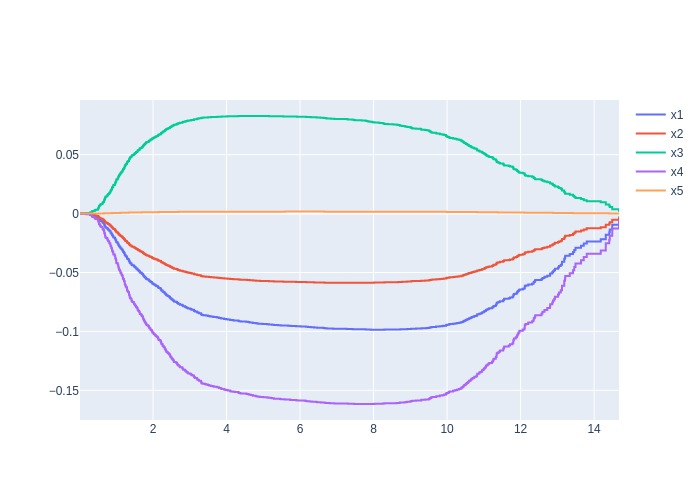

In [14]:
cph_expl = SurvShapExplainer(cph, test_X, test_y)
cph_expl0 = cph_expl(test_X.iloc[[690]]).iloc[0]
plot_expl(cph_expl0)

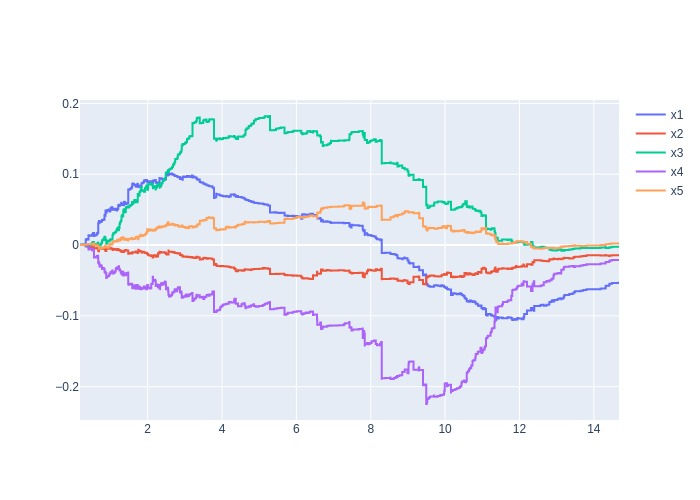

In [15]:
rsf_expl = SurvShapExplainer(rsf, test_X, test_y)
rsf_expl0 = rsf_expl(test_X.iloc[[690]]).iloc[0]
plot_expl(rsf_expl0)

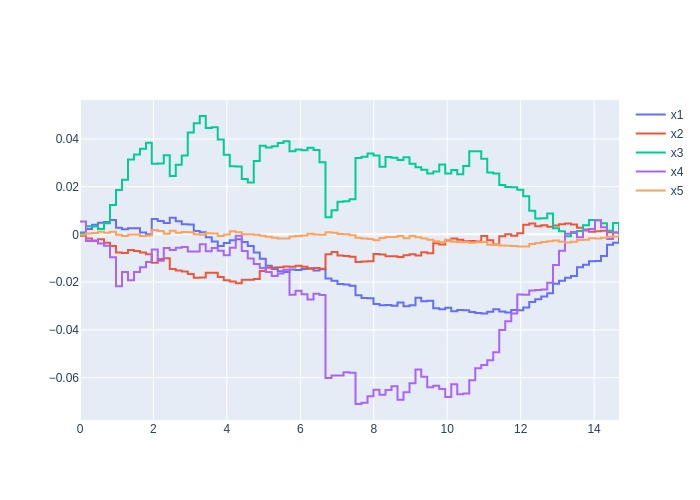

In [16]:
dh_expl = SurvShapExplainer(deephit_, test_X, test_y)
dh_expl0 = dh_expl(test_X.iloc[[690]]).iloc[0]
plot_expl(dh_expl0)

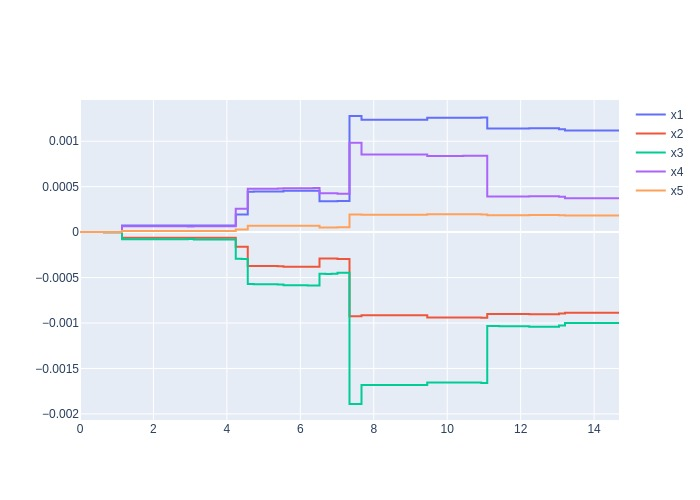

In [17]:
lift_expl = DeepLiftExplainer(deephit_, test_X, test_y)
lift_expl0 = lift_expl(test_X.iloc[[690]]).iloc[0]
plot_expl(lift_expl0)

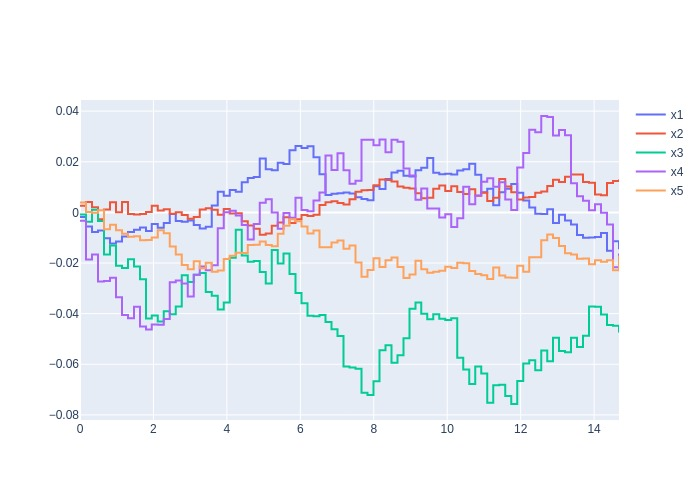

In [18]:
dls_expl = DeepLiftShapExplainer(deephit_, test_X, test_y)
dls_expl0 = dls_expl(test_X.iloc[[690]]).iloc[0]
plot_expl(dls_expl0)

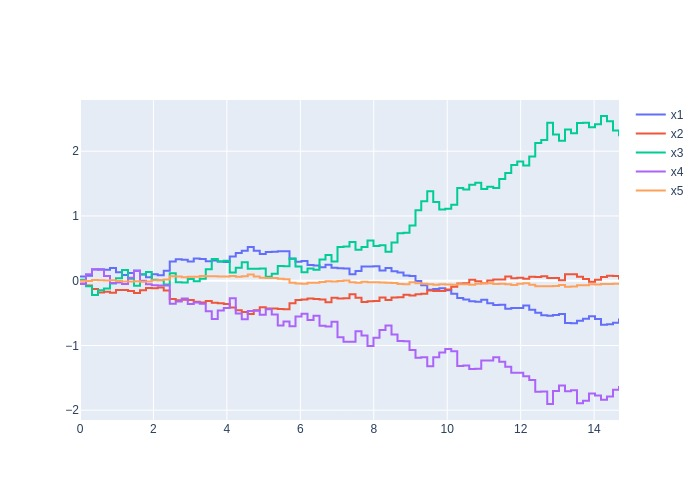

In [19]:
ig_expl = IGExplainer(deephit_, test_X, test_y)
ig_expl0 = ig_expl(test_X.iloc[[690]]).iloc[0]
plot_expl(ig_expl0)

## Real-world case: METABRIC dataset

Note: data and training protocol taken from [example pycox notebook](https://nbviewer.org/github/havakv/pycox/blob/master/examples/deephit.ipynb).

In [20]:
np.random.seed(1234)
_ = torch.manual_seed(123)

### Data

In [21]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [22]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

def pycox_get_x_y(df):
    values = x_mapper.transform(df).astype("float32")
    X = pd.DataFrame(values, columns=x_mapper.transformed_names_)
    _, y = get_x_y(df, ["event", "duration"], 1)
    return X, y

In [23]:
x_mapper.fit(df_train)

x_train, y_train = pycox_get_x_y(df_train)
x_val, y_val = pycox_get_x_y(df_val)
x_test, y_test = pycox_get_x_y(df_test)

In [24]:
net = tt.practical.MLPVanilla(x_train.shape[1], [32, 32], 91, True, 0.1)
deephit_ = DeepHitSingle_(net, alpha=0.2, sigma=0.1)

In [25]:
conf = TrainConf(
    optimizer_fn=lambda net: torch.optim.Adam(net.parameters(), lr=1e-2),
    epochs=100,
    callbacks=[tt.callbacks.EarlyStopping()],
    batch_size=256,
    val_data=(x_val, y_val),
    verbose=True,
)

deephit_ = deephit_.fit(x_train, y_train, conf=conf)

0:	[0s / 0s],		train_loss: 0.8914,	val_loss: 0.7831
1:	[0s / 0s],		train_loss: 0.8337,	val_loss: 0.7821
2:	[0s / 0s],		train_loss: 0.8177,	val_loss: 0.7813
3:	[0s / 0s],		train_loss: 0.8022,	val_loss: 0.7857
4:	[0s / 0s],		train_loss: 0.7879,	val_loss: 0.7898
5:	[0s / 0s],		train_loss: 0.7792,	val_loss: 0.7930
6:	[0s / 0s],		train_loss: 0.7725,	val_loss: 0.7970
7:	[0s / 0s],		train_loss: 0.7632,	val_loss: 0.7998
8:	[0s / 0s],		train_loss: 0.7524,	val_loss: 0.8071
9:	[0s / 0s],		train_loss: 0.7495,	val_loss: 0.8192
10:	[0s / 0s],		train_loss: 0.7335,	val_loss: 0.8220
11:	[0s / 0s],		train_loss: 0.7284,	val_loss: 0.8210
12:	[0s / 0s],		train_loss: 0.7248,	val_loss: 0.8239


In [26]:
deephit_.score(x_test, y_test)

0.685340624867523

### Linear model

In [27]:
cph = CoxPHSurvivalAnalysis()
cph.fit(x_train, y_train)
cph.score(x_test, y_test)

0.6503878926618339

In [28]:
rsf = RandomSurvivalForest(
    random_state=42,
    n_estimators=100,
    min_samples_split=8,
    min_samples_leaf=4,
    max_features=3,
    max_samples=0.8,
)
rsf = rsf.fit(x_train, y_train)
rsf.score(x_test, y_test)

0.6550722794522871

### Explanations

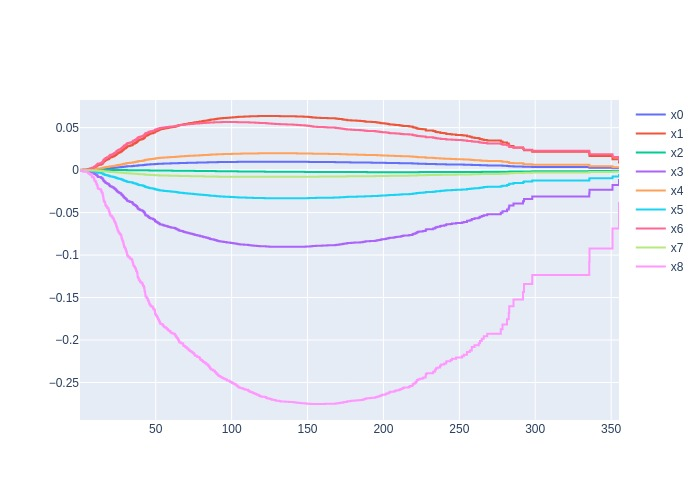

In [29]:
cph_expl = SurvShapExplainer(cph, x_train, y_train)
cph_expl0 = cph_expl(x_test.iloc[[0]]).iloc[0]
plot_expl(cph_expl0)

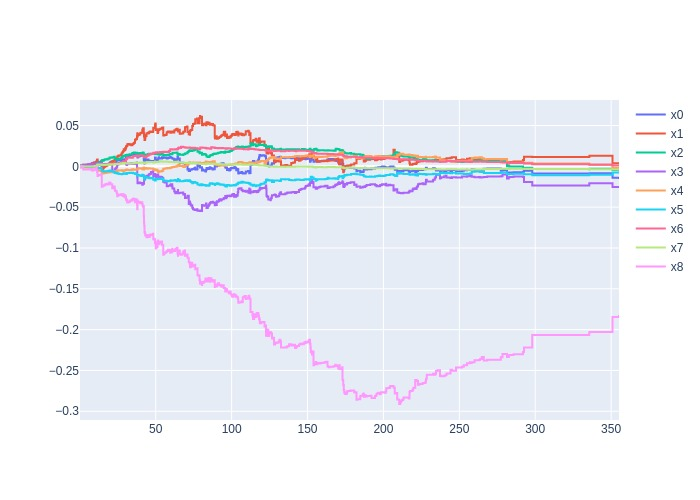

In [30]:
rsf_expl = SurvShapExplainer(rsf, x_train, y_train)
rsf_expl0 = rsf_expl(x_test.iloc[[0]]).iloc[0]
plot_expl(rsf_expl0)

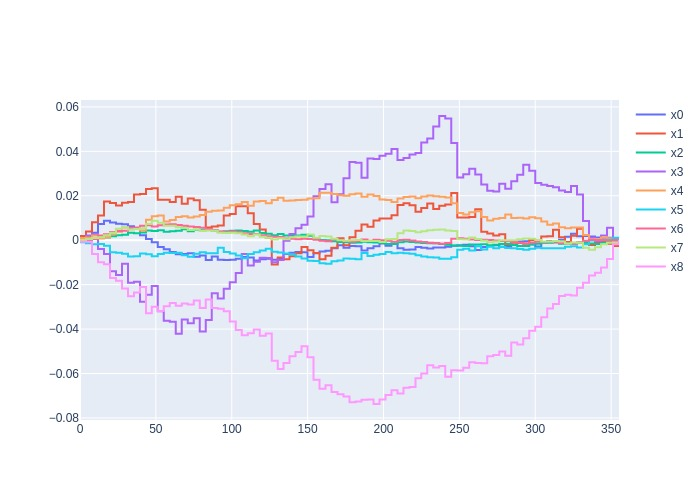

In [31]:
dh_expl = SurvShapExplainer(deephit_, x_train, y_train)
dh_expl0 = dh_expl(x_test.iloc[[0]]).iloc[0]
plot_expl(dh_expl0)

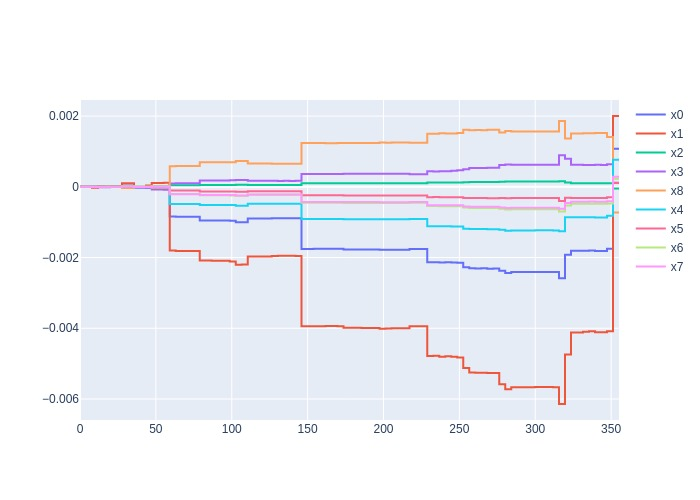

In [32]:
lift_expl = DeepLiftExplainer(deephit_, x_train, y_train)
lift_expl0 = lift_expl(x_test.iloc[[0]]).iloc[0]
plot_expl(lift_expl0)

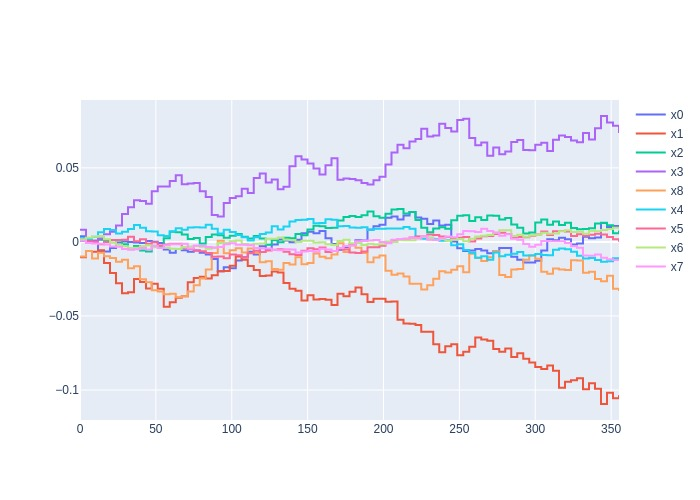

In [33]:
dls_expl = DeepLiftShapExplainer(deephit_, x_train, y_train)
dls_expl0 = dls_expl(x_test.iloc[[0]]).iloc[0]
plot_expl(dls_expl0)

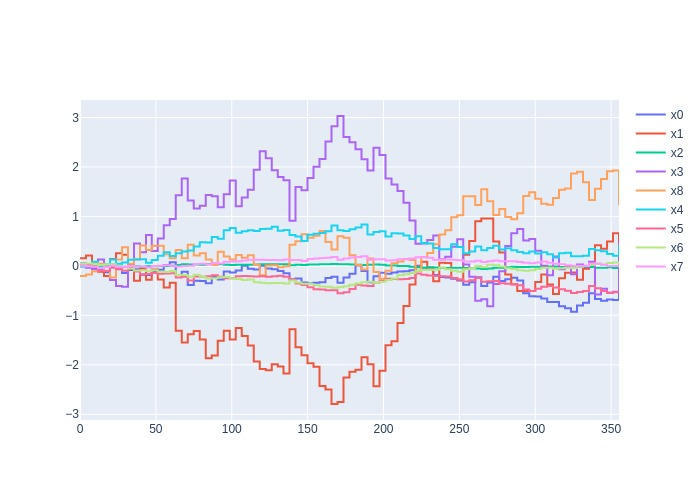

In [34]:
ig_expl = IGExplainer(deephit_, x_train, y_train)
ig_expl0 = ig_expl(x_test.iloc[[0]]).iloc[0]
plot_expl(ig_expl0)